In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import data
import train
from matplotlib import pyplot as plt
import torch
import numpy as np
import json
import random

In [3]:
input_dim=16
k=4
batch_size = 1024

In [4]:
disjoint_mixed_pool = data.create_mixed_clause_pool_random_disjoint(
    global_input_dim=input_dim,
    pool_size=256,
    features_per_and=4,
    seed=0,
)

In [5]:
for _ in range(10):
    formula = random.sample(disjoint_mixed_pool, 4)
    print(formula)

[[(5, False), (6, False), (10, False), (15, False)], [(0, False), (4, False), (6, False), (9, False)], [(1, False), (2, False), (12, False), (14, False)], [(0, False), (1, False), (2, False), (4, False)]]
[[(0, False), (4, False), (6, False), (8, False)], [(1, False), (2, False), (4, False), (8, False)], [(1, False), (10, False), (14, False), (15, False)], [(0, False), (6, False), (10, False), (11, False)]]
[[(1, False), (5, False), (14, False), (15, False)], [(1, False), (3, False), (11, False), (13, False)], [(1, False), (3, False), (5, False), (6, False)], [(5, False), (8, False), (13, False), (15, False)]]
[[(0, False), (3, False), (4, False), (11, False)], [(3, False), (8, False), (12, False), (15, False)], [(0, False), (2, False), (4, False), (7, False)], [(1, False), (3, False), (11, False), (13, False)]]
[[(4, False), (5, False), (7, False), (11, False)], [(0, False), (3, False), (9, False), (14, False)], [(3, False), (9, False), (12, False), (14, False)], [(0, False), (5, Fals

In [6]:
L = 1
R = 10
iterations = 10 # increase
T = 10000

stats = []

for num_clauses in range(L, R):
    for it in range(iterations):
        print(f"num_clauses: {num_clauses}, it: {it}")
        # Randomly select num_clauses clauses from the pool
        formula = random.sample(disjoint_mixed_pool, num_clauses)
        print(formula)
        dset = data.create_dataset(
            cset=formula,
            input_dim=input_dim,
            train_size=10000,
            test_size=1000,
            min_true_vars=0,
            max_true_vars=4*num_clauses,
        )
        train_data, test_data = dset
        max_agg_steps = list(range(100, T+100, 100))
        plot_steps = []
        test_loader = data.create_dataloader(test_data, batch_size=batch_size)
        train_loader = data.create_dataloader(train_data, batch_size=batch_size)

        exp, model = train.run_single_model(
            run_name=f"k{num_clauses}_it{it}",
            max_aggregator_steps=max_agg_steps,
            plot_steps=plot_steps,
            input_dim=input_dim,
            hidden_dim=input_dim,
            num_features_per_clause=k,
            train_loader=train_loader,
            test_loader=test_loader,
            base_dir=".",
            l2_reg_factor=0,
            l1_reg_factor=1e-4,
            seed_offset=iterations*num_clauses+it,
            cset=formula,
            visualize=False,
            loss_diff_th=1e-5,
        )
        train_losses = exp.get_error_history(error_type="train")
        test_losses = exp.get_error_history(error_type="test")
        # print(model.fc1.weight.detach().cpu().numpy())
        cnt_nonzero = (model.fc1.weight.detach().cpu().numpy() > 1e-5).sum()
        print(cnt_nonzero)
        # total params in fc1.weight
        total_params = model.fc1.weight.detach().cpu().numpy().size
        print(total_params)

        l1 = 0.0
        for param in model.parameters():
            l1 += torch.sum(torch.abs(param))
        l1 = l1.item()

        print(train_losses[-10:])
        print(test_losses[-10:])
        stat = {
            "num_clauses": int(num_clauses),
            "train_loss": float(train_losses[-1]),
            "test_loss": float(test_losses[-1]),
            "nonzero_params": int(cnt_nonzero),
            "total_params": int(total_params),
            "train_loss_stability": float(train_losses[-1] - train_losses[-2]),
            "test_loss_stability": float(test_losses[-1] - test_losses[-2]),
            "l1": float(l1)
        }
        stats.append(stat)
        with open("./max_sparsity_stats_4_25.json", "w") as f:
            json.dump(stats, f)


num_clauses: 1, it: 0
[[(10, False), (11, False), (14, False), (15, False)]]
k1_it0: using new random 4-AND formula => [[(10, False), (11, False), (14, False), (15, False)]]
num_batches: 9
122
256
[0.27142887 0.2690858  0.27218435 0.26635957 0.26746228 0.2692644
 0.26809637 0.26816321 0.26779696 0.2686681 ]
[1.e-09 1.e-09 1.e-09 1.e-09 1.e-09 1.e-09 1.e-09 1.e-09 1.e-09 1.e-09]
num_clauses: 1, it: 1
[[(0, False), (6, False), (10, False), (13, False)]]
k1_it1: using new random 4-AND formula => [[(0, False), (6, False), (10, False), (13, False)]]
num_batches: 9
130
256
[0.26975851 0.26897162 0.27090545 0.26776057 0.26819022 0.26940705
 0.26868377 0.26666373 0.26751599 0.26776645]
[1.e-09 1.e-09 1.e-09 1.e-09 1.e-09 1.e-09 1.e-09 1.e-09 1.e-09 1.e-09]
num_clauses: 1, it: 2
[[(5, False), (7, False), (9, False), (10, False)]]
k1_it2: using new random 4-AND formula => [[(5, False), (7, False), (9, False), (10, False)]]
num_batches: 9
139
256
[0.27103769 0.27073393 0.27108685 0.27005779 0.268

KeyboardInterrupt: 

In [ ]:
import json

records = []
with open("./max_sparsity_stats_4_24.json") as f:
    for line in f:
        line = line.strip()
        if not line: continue
        records.append(json.loads(line))


JSONDecodeError: Extra data: line 1 column 11130 (char 11129)

In [ ]:
stats

[{'num_clauses': 1,
  'train_loss': 0.2636001755793889,
  'test_loss': 1e-09,
  'nonzero_params': 140,
  'total_params': 256,
  'train_loss_stability': 0.002448250850041689,
  'test_loss_stability': 0.0,
  'l1': 46.448974609375},
 {'num_clauses': 1,
  'train_loss': 0.2653188722001182,
  'test_loss': 1e-09,
  'nonzero_params': 118,
  'total_params': 256,
  'train_loss_stability': -0.0018415649731953754,
  'test_loss_stability': 0.0,
  'l1': 45.482540130615234},
 {'num_clauses': 1,
  'train_loss': 0.2653188722001182,
  'test_loss': 1e-09,
  'nonzero_params': 118,
  'total_params': 256,
  'train_loss_stability': -0.0018415649731953754,
  'test_loss_stability': 0.0,
  'l1': 45.482540130615234},
 {'num_clauses': 1,
  'train_loss': 0.2653188722001182,
  'test_loss': 1e-09,
  'nonzero_params': 118,
  'total_params': 256,
  'train_loss_stability': -0.0018415649731953754,
  'test_loss_stability': 0.0,
  'l1': 45.482540130615234},
 {'num_clauses': 1,
  'train_loss': 0.2653188722001182,
  'test_l

Read saved json

In [28]:
stats = json.load(open("./max_sparsity_stats_4_24.json"))
L = min(stats, key=lambda x: x["num_clauses"])["num_clauses"]
R = max(stats, key=lambda x: x["num_clauses"])["num_clauses"]

In [34]:
stats_avg = []
for num_clauses in range(L, R+1):
    s = {}
    for key in stats[0].keys():
        s[key] = [s[key] for s in stats if s["num_clauses"] == num_clauses]
        s[key] = np.mean(s[key])
    stats_avg.append(s)

stats_std = []
for num_clauses in range(L, R+1):
    s = {}
    for key in stats[0].keys():
        s[key] = [s[key] for s in stats if s["num_clauses"] == num_clauses]
        s[key] = np.std(s[key])
    stats_std.append(s)

In [35]:
stats_std

[{'num_clauses': 0.0,
  'train_loss': 0.0007190606480800716,
  'test_loss': 2.0679515313825692e-25,
  'nonzero_params': 6.655256064270157,
  'total_params': 0.0,
  'train_loss_stability': 0.001282799296886106,
  'test_loss_stability': 0.0,
  'l1': 0.30320583334968393},
 {'num_clauses': 0.0,
  'train_loss': 5.551115123125783e-17,
  'test_loss': 2.0679515313825692e-25,
  'nonzero_params': 0.0,
  'total_params': 0.0,
  'train_loss_stability': 0.0,
  'test_loss_stability': 0.0,
  'l1': 0.0},
 {'num_clauses': 0.0,
  'train_loss': 0.0,
  'test_loss': 2.0679515313825692e-25,
  'nonzero_params': 0.0,
  'total_params': 0.0,
  'train_loss_stability': 0.0,
  'test_loss_stability': 0.0,
  'l1': 0.0},
 {'num_clauses': 0.0,
  'train_loss': 0.0,
  'test_loss': 2.0679515313825692e-25,
  'nonzero_params': 0.0,
  'total_params': 0.0,
  'train_loss_stability': 0.0,
  'test_loss_stability': 0.0,
  'l1': 0.0},
 {'num_clauses': 0.0,
  'train_loss': 1.1102230246251565e-16,
  'test_loss': 2.0679515313825692e-

In [36]:
x = list(range(L, R+1))
nonzero_params = [s["nonzero_params"] for s in stats_avg]
train_loss = [s["train_loss"] for s in stats_avg]
test_loss = [s["test_loss"] for s in stats_avg]
train_loss_stability = [s["train_loss_stability"] for s in stats_avg]
test_loss_stability = [s["test_loss_stability"] for s in stats_avg]
l1 = [s["l1"] for s in stats_avg]

In [ ]:
nonzero_params_std

[6.655256064270157, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

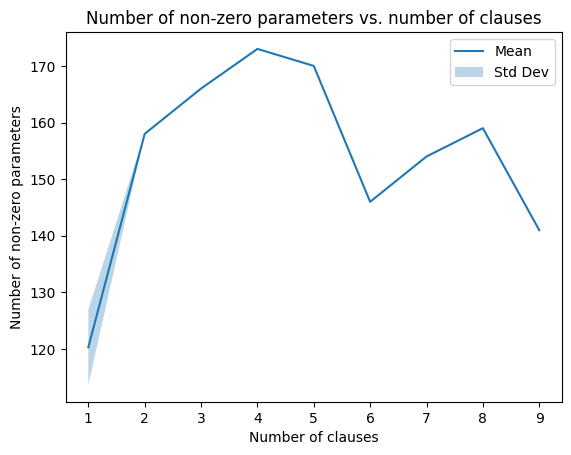

In [38]:
nonzero_params_std = [s["nonzero_params"] for s in stats_std]

# Ensure data is in numpy arrays for easier calculations
x_np = np.array(x)
nonzero_params_np = np.array(nonzero_params)
nonzero_params_std_np = np.array(nonzero_params_std)

# Plot the mean line
plt.plot(x_np, nonzero_params_np, label='Mean')

# Add the shaded standard deviation range
plt.fill_between(x_np,
                 nonzero_params_np - nonzero_params_std_np,
                 nonzero_params_np + nonzero_params_std_np,
                 alpha=0.3, # Adjust transparency as needed
                 label='Std Dev')

plt.xlabel("Number of clauses")
plt.ylabel("Number of non-zero parameters")
plt.title("Number of non-zero parameters vs. number of clauses")
plt.legend() # Show legend to identify mean and std dev
plt.show()

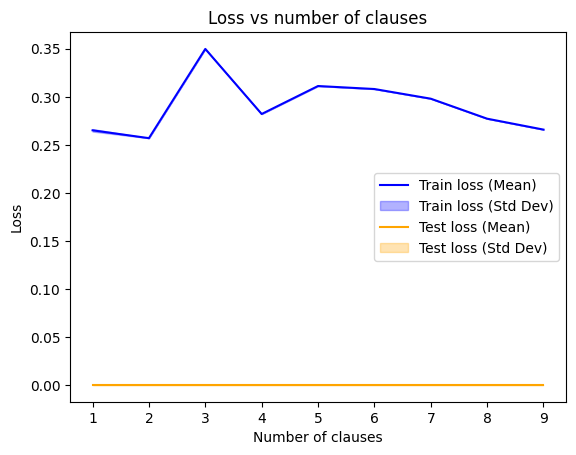

In [39]:
train_loss_std = [s["train_loss_stability"] for s in stats_std]
test_loss_std = [s["test_loss_stability"] for s in stats_std]

# Ensure data is in numpy arrays for easier calculations
x_np = np.array(x)
train_loss_np = np.array(train_loss)
train_loss_std_np = np.array(train_loss_std)
test_loss_np = np.array(test_loss)
test_loss_std_np = np.array(test_loss_std)

# Plot the mean train loss line
plt.plot(x_np, train_loss_np, label='Train loss (Mean)', color='blue') # Assign color for clarity
# Add the shaded standard deviation range for train loss
plt.fill_between(x_np,
                 train_loss_np - train_loss_std_np,
                 train_loss_np + train_loss_std_np,
                 alpha=0.3, color='blue', # Match color with the mean line
                 label='Train loss (Std Dev)')

# Plot the mean test loss line
plt.plot(x_np, test_loss_np, label='Test loss (Mean)', color='orange') # Assign color for clarity
# Add the shaded standard deviation range for test loss
plt.fill_between(x_np,
                 test_loss_np - test_loss_std_np,
                 test_loss_np + test_loss_std_np,
                 alpha=0.3, color='orange', # Match color with the mean line
                 label='Test loss (Std Dev)')

plt.xlabel("Number of clauses")
plt.ylabel("Loss")
plt.title("Loss vs number of clauses")
plt.legend() # Show legend
plt.show()

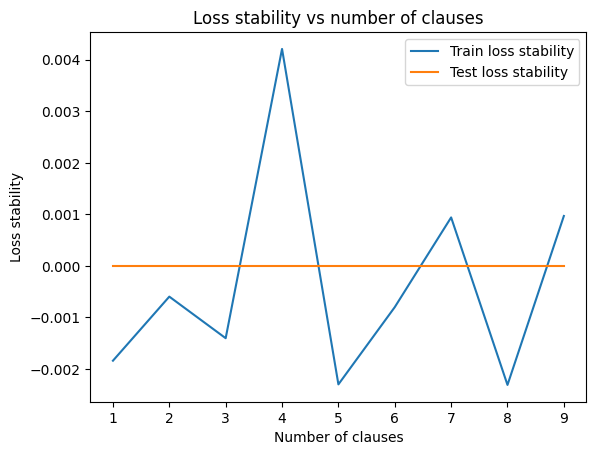

In [12]:
plt.plot(x, train_loss_stability)
plt.plot(x, test_loss_stability)
plt.xlabel("Number of clauses")
plt.ylabel("Loss stability")
plt.title("Loss stability vs number of clauses")
plt.legend(["Train loss stability", "Test loss stability"])
plt.show()

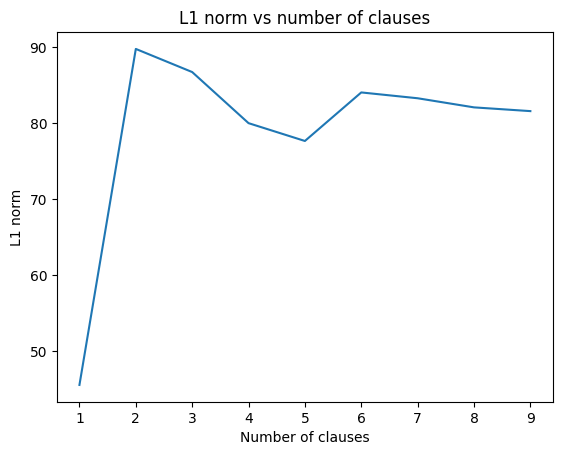

In [13]:
plt.plot(x, l1)
plt.xlabel("Number of clauses")
plt.ylabel("L1 norm")
plt.title("L1 norm vs number of clauses")
plt.show()